In [2]:
import numpy as np
from sympy.physics.wigner import wigner_3j
import matplotlib.pyplot as plt
import cmath
from scipy.special import lpmn, legendre
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from matplotlib.colors import LogNorm

from legendre import *

In [3]:
au2cm = 219474.63
au2ps = 2.4188843265864e-5
au2eV = 27.2
au2A = 0.529177
Db2au = 0.393456

# Functions

In [4]:
def potential( r, th, C_12, alpha, mu ):
    return C_12 / r**12 - alpha * mu**2 / 2 / r**6 * ( 1 + 3 * np.cos(th)**2 )

def force_field( r, th, C_12, alpha, mu ):
    F_r = + 12 * C_12 / r**13 - 3 * alpha * mu**2 / r**7 * ( 1 + 3 * np.cos( th )**2 )
    F_th = - 3 * alpha * mu**2 / 2 / r**6 * np.sin( 2 * th )

    return F_r, F_th

In [5]:
def evolution( t, V, C_12, alpha, mu, m_Ne, m_HYQ, th_arr, Pleg ):

    mass = 1./( 1./m_Ne + 1./m_HYQ )

    r = V[0]
    th = V[1]

    Psi = V[4:]

    der_V = np.zeros_like( V )

    der_V[0] = V[2] / mass
    der_V[1] = 4 * V[3] / m_HYQ

    # F_r, F_th = force_field( r, th_arr, C_12, alpha, mu )

    # der_V[2] = np.sum( F_r * np.abs(np.matmul( np.conj(np.transpose(Pleg)), Psi ))**2 )
    # der_V[3] = np.sum( F_th * np.abs(np.matmul( np.conj(np.transpose(Pleg)), Psi ))**2 )
    
    der_V[2], der_V[3] = force_field( r, th, C_12, alpha, mu )

    # Pot = np.matmul( Pleg, np.matmul( np.diag( potential( r, th_arr, C_12, alpha, mu ) ), np.conj(np.transpose( Pleg ) ) ) )

    Pot = Pleg @ np.diag( potential( r, th_arr, C_12, alpha, mu ) ) @ np.conj(np.transpose( Pleg ) )

    der_V[4:] = - 1j * np.matmul( Pot, Psi )

    return der_V

# Parameters

In [6]:
# ------------------potential------------------------
C_12 = 2.5e7
mu = 2.38 * Db2au
alpha = 27.6 / au2A**3

# ------------------particles------------------------
Be = 5614 * 1.5198298460570 * 1e-10
m_HYQ = 110 * 1822.8884

m_Ne = 20 * 1822.8884

# ---------------initial conditions------------------
E_col = 0.5 / au2eV

j_init = 0
omega = 0

r_0 = 50.
th_0 = np.pi/4.


# --------------simulation parameters----------------
t_max = 10 / au2ps
N_states = 141
N_t = 1000

# Simulation

In [7]:

j_max = N_states - 1 + abs( omega )
m_eff = 1./( 1./m_Ne + 1./m_HYQ )
Re = np.sqrt( 2./m_HYQ/Be )

l_arr = np.arange( 0, N_states ) + abs(omega)
E_rot = Be * l_arr * ( l_arr + 1 )

Pleg, x_arr, w = get_Pleg_matrix( N_states, omega )
lap = get_laplacian_matrix( N_states, omega )
# x_arr, w = np.polynomial.legendre.leggauss(N_states)
th_arr = np.arccos(x_arr)

def Pleg_t( t ):
    return np.diag( np.exp( 1j * E_rot * t ) ) @ Pleg

In [8]:
func = lambda t, V: evolution( t, V, C_12, alpha, mu, m_Ne, m_HYQ, th_arr=th_arr, Pleg = Pleg_t(t) )

V0 = np.zeros( N_states + 4, dtype=np.complex64 )

V0[0] = r_0
V0[1] = th_0

V0[2] = -np.sqrt( 2 * E_col * m_eff )
V0[3] = ( j_init + 0.5 ) / Re

# angular initial state
# V0[4:] = np.sqrt(w) * np.sqrt( j_init + 0.5 ) * legendre( j_init )( x_arr ) 

# spherical harmonics initial state
V0[4+j_init - abs(omega)] = 1.0

t_eval = np.linspace( 0, t_max, N_t )


sol = solve_ivp(func, [0, t_max], V0, t_eval = None, atol=1e-7, rtol=1e-5, max_step = 1000)


print( sol )

t_eval = sol.t
N_t = len( t_eval )

r_t = sol.y.T[:,0]
th_t = sol.y.T[:,1]
Psi_t = sol.y.T[:,4:]

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.586e-01 ...  4.130e+05  4.134e+05]
        y: [[ 5.00000000e+01+0.00000000e+00j
              4.99993902e+01+0.00000000e+00j ...
              3.81568072e+02+0.00000000e+00j
              3.81984178e+02+0.00000000e+00j]
            [ 7.85398185e-01+0.00000000e+00j
              7.85399815e-01+0.00000000e+00j ...
             -1.18818954e+02+0.00000000e+00j
             -1.18950992e+02+0.00000000e+00j]
            ...
            [ 0.00000000e+00+0.00000000e+00j
              2.23498317e-28-5.97407002e-26j ...
             -5.13272906e-18-4.88608067e-18j
             -5.13272906e-18-4.88608067e-18j]
            [ 0.00000000e+00+0.00000000e+00j
             -1.02644665e-26+2.24486163e-24j ...
              7.67490287e-16-5.34208156e-16j
              7.67490287e-16-5.34208156e-16j]]
      sol: None
 t_events: None
 y_events: None
     nfev: 2984
     njev

In [9]:
Psi_th_t = np.zeros_like( Psi_t )

for i in range(N_t):
    Psi_th_t[i, :] = np.matmul( Psi_t[i,:], np.conj( Pleg_t(t_eval[i]) ) )
# Psi_th_t = np.matmul( Psi_t, Pleg )

# Data loading

In [23]:
alig_j = np.reshape( loadmat( "../data/alignment.mat" )['allignment'], (-1) )
t_j = np.reshape( loadmat( "../data/time.mat" )['t'], (-1) )
V_j = loadmat( "../data/Rho_p_sol.mat" )['Rho_P_sol']
cos_j = loadmat( "../data/cos2.mat" )['Vt']
# print( loadmat( "../data/cos2.mat" ) )


N_j = len( t_j )

Psi_j = V_j[:,4:]
Psi_th_j = np.zeros( (N_j, N_states), np.complex64 )
aligment_jc = np.zeros_like( t_j )
aligment_j = np.zeros_like( t_j )

a_cos_j = np.abs(cos_j)

l_arr_cut = np.arange( 0, 141, 2 )
l_vert, l_hor = np.meshgrid( l_arr_cut, l_arr_cut )
def time_prop( t ):
    return np.exp( - 1j * Be * ( l_vert*(l_vert + 1) - l_hor*(l_hor + 1) ) * t )


for i in range(N_j):
    # Psi_th_j[i, :] = np.matmul( Psi_j[i,:], np.conj( Pleg_t(t_j[i])[0:141:2,:] ) )
    
    cos = ( Pleg_t(t_j[i])[0:141:2,:] * np.cos(th_arr)**2 ) @ np.conj(np.transpose( Pleg_t(t_j[i])[0:141:2,:] ) )
    
    aligment_j[i] = np.abs( np.conj(Psi_j[i,:]) @ cos @ Psi_j[i,:] )
    aligment_jc[i] = np.abs( np.conj(Psi_j[i,:]) @ ( a_cos_j * time_prop( t_j[i] ) ) @ Psi_j[i,:] )

pass
# Psi_th_t = np.matmul( Psi_t, Pleg )

In [27]:
data = np.loadtxt( r"../data/hyq_0.5_alignment.dat" )

# plt.plot( data[0,:], data[1,:] )

t_m = data[0,:]
alignment_m = data[1,:]

delta_t = 30 / np.sqrt( 2 * E_col / m_eff ) * au2ps 

# print( 30 / np.sqrt( 2 * E_col / m_eff ) * au2ps )

pass

# Data Plotting

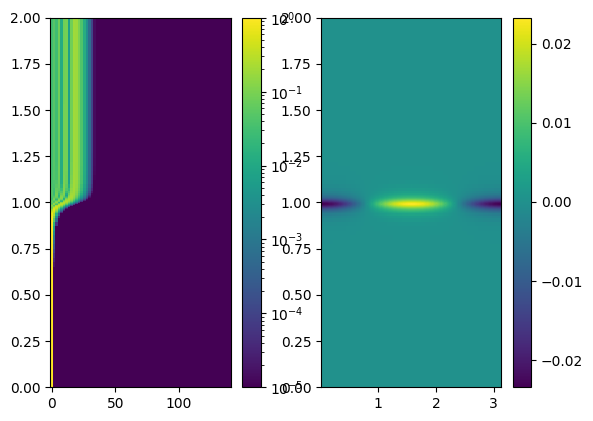

In [33]:
tlim = (0,2)

plt.subplot(1, 2, 1)

plt.pcolor( l_arr[j_init%2::2], 
           t_eval * au2ps, 
           np.abs( Psi_t[:, j_init%2::2] )**2,
           norm=LogNorm(vmin = 1e-5, vmax = 1) )

# plt.pcolor( np.arccos( x_arr ), t_eval * au2ps, np.abs( Psi_th_t )**2 / w, norm=LogNorm() )

plt.colorbar()
plt.ylim( tlim )
# plt.xlim( -0.5, 50 )

plt.subplot(1, 2, 2)

th_gr, r_gr = np.meshgrid( np.arccos( x_arr ), np.abs(r_t) )

V_t_arr = potential( r_gr, th_gr, C_12, alpha, mu )

plt.pcolor( np.arccos( x_arr ), t_eval * au2ps, V_t_arr - np.matmul(np.reshape(np.mean( V_t_arr, axis = 1 ), (-1,1)), np.reshape(np.ones(N_states), (1,-1))) )

plt.colorbar()

plt.ylim( tlim )

pass

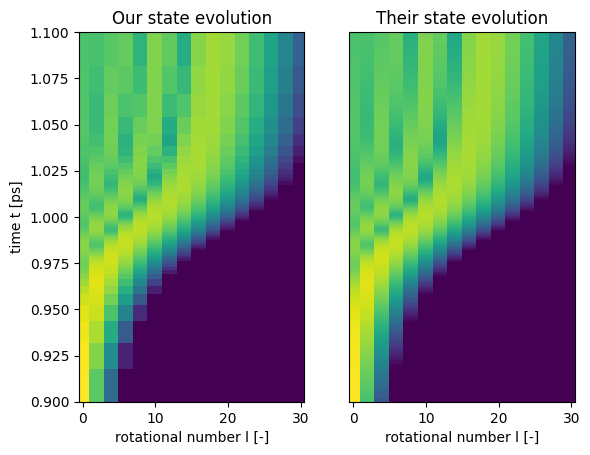

In [34]:

l_lim = [-0.5, 30.5]
t_lim = [0.9, 1.1]
# t_lim = [0, 2]

xlab = "rotational number l [-]"
ylab = "time t [ps]"

plt.subplot( 1, 2, 1)

plt.pcolor( l_arr[j_init%2::2], 
           t_eval * au2ps, 
           np.abs( Psi_t[:, j_init%2::2] )**2,
           norm=LogNorm(vmin = 1e-5, vmax = 1) )

plt.xlim( l_lim )
plt.ylim( t_lim )

plt.title( "Our state evolution" )

plt.xlabel( xlab )
plt.ylabel( ylab )

plt.subplot( 1, 2, 2)

plt.pcolor( l_arr[j_init%2::2], 
           t_j * au2ps, 
           np.abs( Psi_j )**2,
           norm=LogNorm(vmin = 1e-5, vmax = 1) )

plt.tick_params(left = False, labelleft = False) 

plt.xlim( l_lim )
plt.ylim( t_lim )

plt.title( "Their state evolution" )
plt.xlabel( xlab )

plt.savefig( "vector_2d_close.png" )

pass

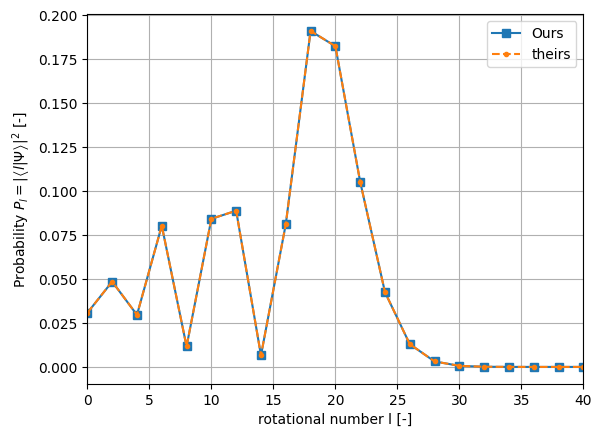

In [35]:
plt.plot( l_arr[j_init%2::2], np.abs( Psi_t[-1, j_init%2::2] )**2, '-s', label = "Ours" )
plt.plot( l_arr[j_init%2::2], np.abs( Psi_j[-1, :] )**2, '--.', label = "theirs" )

plt.legend()

plt.grid()
plt.xlim( 0, 40 )

plt.xlabel( xlab )
plt.ylabel( r"Probability $P_l = |\left< l | \Psi \right> |^2 $ [-]" )

plt.savefig( "Vector_at_the_end.pdf" )

pass

/home/akgrabowsk/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(5.62446000073215+0j)
(-37286.70529377945+0j)
0.7173993758688637


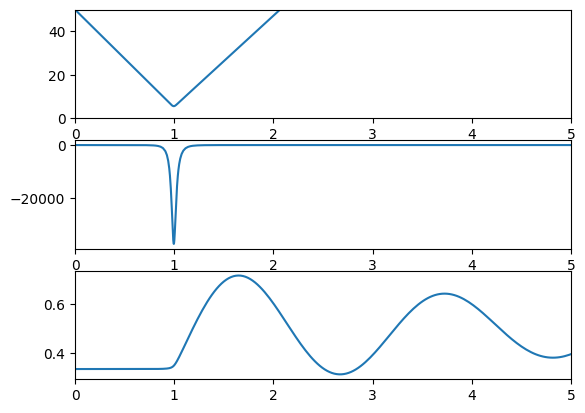

In [30]:

tlim = [0,5]

plt.subplot( 3, 1, 1 )
plt.plot( t_eval * au2ps, r_t )
plt.ylim( 0, 50 )
plt.xlim( tlim )

print( np.min(r_t) )

plt.subplot( 3, 1, 2 )

pulse = - alpha * mu**2 / 2 / r_t**6 * ( 1 + 3 * np.sum( np.cos( th_arr )**2 * np.abs(Psi_th_t)**2, axis = 1 ) ) / Be

plt.plot( t_eval * au2ps, pulse )
plt.xlim( tlim )
print( np.min(pulse) )


plt.subplot( 3, 1, 3 )

aligment = np.sum( np.abs( Psi_th_t )**2 * x_arr**2, axis = 1 )
# aligment_j = np.sum( np.abs( Psi_th_j )**2 * x_arr**2, axis = 1 )

plt.plot( t_eval * au2ps, aligment)
plt.xlim( tlim )



# plt.plot( t_eval * au2ps, np.cos(th_t) )
print( np.max( aligment ) )
# plt.ylim( 0.33, 0.4 )

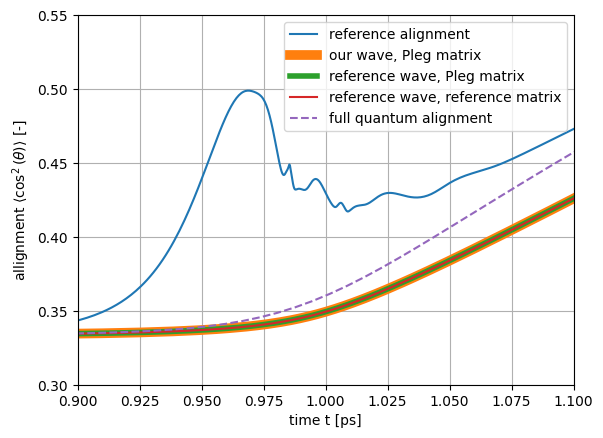

In [32]:

plt.plot( t_j * au2ps, alig_j, label = "reference alignment" )
plt.plot( t_eval * au2ps, aligment, linewidth = 7, label = "our wave, Pleg matrix")
plt.plot( t_j * au2ps, aligment_j, linewidth = 4, label = "reference wave, Pleg matrix" )
plt.plot( t_j * au2ps, aligment_jc, label = r"reference wave, reference matrix" )
plt.plot( t_m+delta_t, alignment_m, '--', label = "full quantum alignment" )

plt.grid()

plt.ylabel( r"allignment $\left< \cos^2(\theta) \right>$ [-]" )
plt.xlabel( "time t [ps]" )

# plt.xlim( 0, 5 )

plt.xlim( 0.9, 1.1 )
plt.ylim( 0.3, 0.55 )

plt.legend()

plt.savefig( "allignment_close.pdf" )

pass

# Potential plotting

-1.0580290275387607


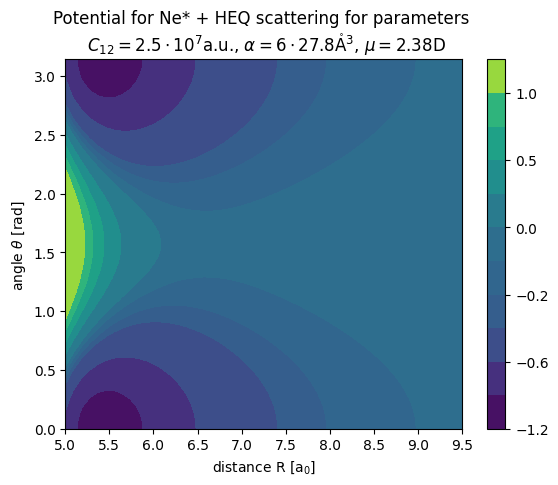

In [16]:

r = np.linspace( 5, 9.5 )
th = np.linspace( 0, np.pi )

r_gr, th_gr = np.meshgrid( r, th )

Db2au = 0.393456 
au2A = 0.529177
au2eV = 27.2

C_12 = 2.5e7
mu = 2.38 * Db2au
alpha = 6 * 27.8 / au2A**3

# print(C_12, mu, alpha)

V = C_12 / r_gr**12 - mu**2 * alpha / r_gr**6 / 2 * ( 1 + 3 * np.cos( th_gr )**2 )

# V = np.clip( V, -1/au2eV, 0 )

print( np.min( V ) * au2eV )

plt.contourf( r_gr, th_gr, V * au2eV, levels = [-1.2, -0.9, -0.6, -0.3, -0.2, -0.1, 0.0, 0.25, 0.5, 0.75, 1.0, 2.0] )
plt.colorbar()

plt.title( "Potential for Ne* + HEQ scattering for parameters \n" + 
          r" $C_{12} = 2.5 \cdot 10^7 $a.u., $\alpha = 6 \cdot 27.8 \mathring{\mathrm{A}}^3$, $\mu = 2.38$D" )
plt.xlabel( r"distance R [a$_0$]" )
plt.ylabel( r"angle $\theta$ [rad] " )

# plt.savefig( "HYQ_potential_modified_parameters.pdf" )

pass